# E-commerce Recommendation System

Recommendation systems are essential tools for e-commerce platforms, aiming to suggest relevant items to users based on various factors. For this notebook, we'll focus on a content-based recommendation approach, utilizing product ratings from the dataset.


## 1. Loading and Preprocessing Data

Before diving into the recommendation process, we need to load our dataset and preprocess it to ensure it's in a usable format. This step involves handling missing values and transforming data types if necessary.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

In [2]:
amazon_sales_data = pd.read_csv('Amazon_Sales_Data.csv')
amazon_sales_data = amazon_sales_data.dropna()
amazon_sales_data.head()


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


## 2. Basic Statistics

Understanding the distribution of ratings is crucial. By calculating some basic statistics, we can get insights into the general behavior of users when rating products.

- **C**: Represents the mean rating across all products. It provides an average perspective of user ratings.
- **m**: Specifies the minimum number of ratings required for a product to be considered. Setting it at the 50th percentile ensures a balance between products with many ratings and those with few but potentially high ratings.

In [3]:
amazon_sales_data['rating'] = pd.to_numeric(amazon_sales_data['rating'], errors='coerce')

In [4]:
# Calculate C, the mean rating across all products
C = amazon_sales_data['rating'].mean()

# Calculate the number of ratings for the 50th percentile (you can adjust this threshold)
m = amazon_sales_data['product_id'].value_counts().quantile(0.5)

## 3. Filter Products and Compute Ratings

To provide effective recommendations, we prioritize products with a significant number of reviews. This approach ensures a balance between popularity and quality. In this step:

- Products with fewer reviews than our threshold `m` are filtered out.
- For the remaining products, we calculate their average rating.


In [5]:
# Filter out products that have a number of ratings below the threshold
qualified_products = amazon_sales_data.groupby('product_id').filter(lambda x: len(x) >= m)

# Compute the average rating and rating count for each product
average_ratings = qualified_products.groupby('product_id')['rating'].mean()
rating_counts = qualified_products.groupby('product_id')['rating'].count()


## 4. Calculate Weighted Ratings and Sort Products

Merely using average ratings can be misleading, especially for products with fewer reviews. To counteract this, we employ a weighted rating system, which considers both the volume and the quality of the ratings.

The formula ensures that products with a higher number of reviews carry more weight, preventing items with a small number of high ratings from dominating the top spots.


In [6]:
# Calculate the weighted rating for each product using the IMDb formula
weighted_ratings = ((rating_counts / (rating_counts + m) * average_ratings) + 
                    (m / (rating_counts + m) * C))

# Sort products by weighted rating in descending order
most_popular = weighted_ratings.sort_values(ascending=False)


1. Using the IMDb weighted rating formula, we calculate a score for each product that takes into account both its average rating and the number of ratings it has received. Products with a higher number of ratings are given more weight, preventing products with very few (but potentially high) ratings from dominating the top spots.
2. The products are then sorted by this weighted rating in descending order to get the most popular products.

### ## 5. Display the Results

With the weighted ratings calculated, we can now display the top products. The result will be a list of items that strike a balance between their average rating and the quantity of feedback they've received.
Display the Results

In [7]:
most_popular.head(10)

product_id
B0BP7XLX48    4.548358
B09ZHCJDP1    4.548358
B0BR4F878Q    4.448358
B0BQ3K23Y1    4.448358
B0B53DS4TF    4.448358
B0B9BXKBC7    4.432239
B09C6HXFC1    4.399179
B0BM9H2NY9    4.398358
B09WN3SRC7    4.398358
B0BP89YBC1    4.398358
Name: rating, dtype: float64

<Axes: xlabel='product_id'>

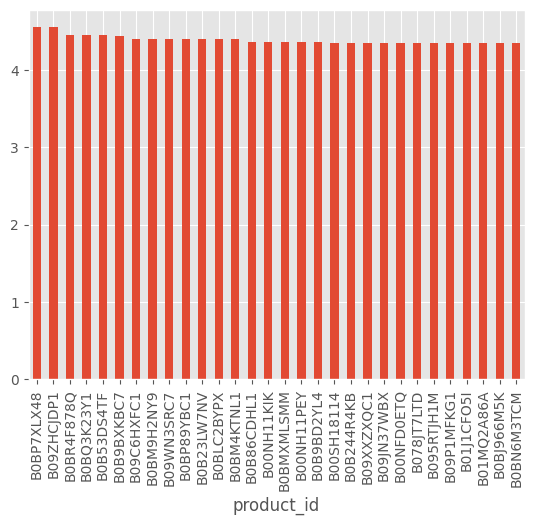

In [8]:
most_popular.head(30).plot(kind = "bar")

Finally, we display the top 10 products based on their weighted ratings and its corresponding chart, which provides a balanced recommendation based on both the quality (average rating) and quantity (number of ratings) of feedback they've received.

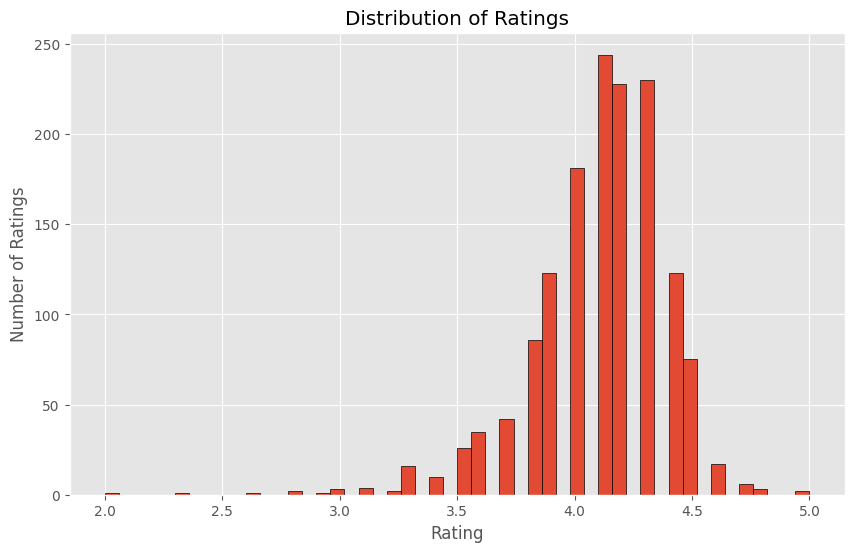

In [9]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
amazon_sales_data['rating'].hist(bins=50, edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.grid(True)
plt.show()


## Conclusion

Through this notebook, we've constructed a content-based recommendation system that suggests products based on their ratings. The weighted rating system ensures a fair balance between popularity and quality, providing users with reliable product recommendations. As the dataset grows or evolves, it would be beneficial to retrain the model to reflect the most current user preferences.
